In [1]:
# !pip install sqlalchemy
# !pip install backtrader-plotting bokeh

In [2]:
import yfinance as yf
ticker = yf.Ticker('AAPL')
data = ticker.history(period='60d', interval='5m')
print(f"Downloaded {len(data)} records")
print(data.head())


Downloaded 4644 records
                                 Open        High         Low       Close  \
Datetime                                                                    
2025-05-22 09:30:00-04:00  200.714996  201.442200  199.699997  199.960007   
2025-05-22 09:35:00-04:00  199.970001  201.410004  199.789993  201.029999   
2025-05-22 09:40:00-04:00  201.000000  201.110397  200.197098  200.369995   
2025-05-22 09:45:00-04:00  200.380005  200.770004  200.289993  200.645004   
2025-05-22 09:50:00-04:00  200.649994  201.039993  200.509995  200.750000   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2025-05-22 09:30:00-04:00  4452916        0.0           0.0  
2025-05-22 09:35:00-04:00  1172510        0.0           0.0  
2025-05-22 09:40:00-04:00   890747        0.0           0.0  
2025-05-22 09:45:00-04:00   952484        0.0           0.0  
2025-05-22 09:50:00-04:00   891207        0.0           0.0  


In [3]:
from IPython.display import IFrame
from IPython.display import Image

📊 Loading AAPL data...
✅ Loaded 355 records
💰 Starting: $100,000.00
BUY: 2023-08-07 at $176.88
SELL: 2023-11-16 at $188.12
BUY: 2024-01-04 at $180.38
SELL: 2024-05-15 at $188.62
💰 Final: $100,019.12
📈 Profit: $19.12
📈 Return: 0.02%
📉 Max DD: 2.97%
💰 Final: $100,019.12


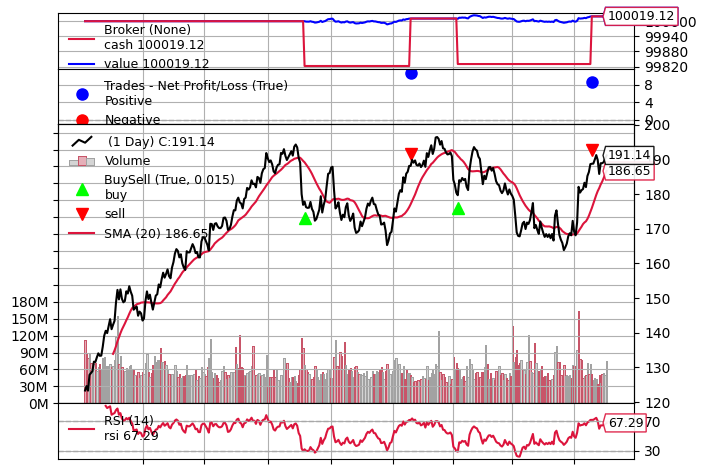

In [4]:
# Create the working strategy file
# cat > working_strategy.py << 'EOF'
#!/usr/bin/env python3
import backtrader as bt
import pandas as pd
import psycopg2, bokeh
import matplotlib.pyplot as plt

# Update this password
DB_CONFIG = {
    'host': 'localhost',
    'database': 'trading_historical', 
    'user': 'trading_bot',
    'password': 'your_secure_password'  # ⚠️ UPDATE THIS
}

class SimpleStrategy(bt.Strategy):
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=14)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.order = None
        
    def next(self):
        if self.order:
            return
            
        if not self.position and self.rsi[0] < 30:
            self.order = self.buy()
            print(f"BUY: {self.data.datetime.date(0)} at ${self.data.close[0]:.2f}")
            
        elif self.position and self.rsi[0] > 70:
            self.order = self.sell()
            print(f"SELL: {self.data.datetime.date(0)} at ${self.data.close[0]:.2f}")
    
    def notify_order(self, order):
        if order.status == order.Completed:
            self.order = None

from sqlalchemy import create_engine


def plot_results(cerebro, results):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(111, ylabel='Portfolio Value ($)')

    # Get the dates and values from the backtest results
    portfolio_values = results[0].analyzers.returns.get_analysis()['rnorm']
    dates = [bt.num2date(x) for x in portfolio_values.keys()]
    values = list(portfolio_values.values())
    
    # Plot the portfolio value
    ax1.plot(dates, values, color='blue', label='Portfolio Value')
    
    # Optional: You can add trade markers if you want
    # This requires a bit more logic to extract trade info
    
    plt.title('Backtest Results')
    plt.legend()
    plt.show()
    
def get_data():
    # Create a database URL string
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    engine = create_engine(db_url)
    
    query = """
    SELECT p.timestamp as datetime, p.open, p.high, p.low, p.close, p.volume
    FROM historical_prices p
    WHERE p.symbol = 'AAPL' AND p.timestamp >= '2023-01-01' AND p.timestamp <= '2024-06-01'
    ORDER BY p.timestamp;
    """
    # No need to open/close the connection, SQLAlchemy handles it
    df = pd.read_sql(query, engine, parse_dates=['datetime'])
    df.set_index('datetime', inplace=True)
    return df

def run_backtest():
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SimpleStrategy)
    
    print("📊 Loading AAPL data...")
    data = get_data()
    print(f"✅ Loaded {len(data)} records")
    
    bt_data = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(bt_data)
    
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    
    print(f"💰 Starting: ${cerebro.broker.getvalue():,.2f}")
    
    results = cerebro.run()

    # cerebro.plot()
    print(f"💰 Final: ${cerebro.broker.getvalue():,.2f}")
    
    strat = results[0]
    returns = strat.analyzers.returns.get_analysis()
    drawdown = strat.analyzers.drawdown.get_analysis()
    
    profit = cerebro.broker.getvalue() - 100000
    print(f"📈 Profit: ${profit:,.2f}")
    print(f"📈 Return: {returns['rtot']:.2%}")
    print(f"📉 Max DD: {drawdown['max']['drawdown']:.2%}")

    # cerebro.plot(style='bokeh')

    # Save the plot to a file instead of trying to display it directly
    # cerebro.plot(style='bokeh', filename='report.html', iplot=False)
    print(f"💰 Final: ${cerebro.broker.getvalue():,.2f}")
    # plot_results(cerebro, results)

    cerebro.plot(iplot=False, filename='./backtest_plot.png')
    # Image(filename='./backtest_plot.png')
    
    # Display the saved HTML file in the notebook
    # IFrame(src='report.html', width='100%', height=600)

if __name__ == "__main__":
    run_backtest()
# EOF

# Update the password and run
# nano working_strategy.py  # Update password
# python working_strategy.py

📊 Loading AAPL data...
✅ Loaded 355 records
💰 Starting Portfolio Value: $100,000.00
BUY SIGNAL: 2023-08-07 at $176.88
SELL SIGNAL: 2023-11-16 at $188.12
BUY SIGNAL: 2024-01-04 at $180.38
SELL SIGNAL: 2024-05-15 at $188.62
💰 Final Portfolio Value: $100,019.12

📊 PERFORMANCE SUMMARY:
💰 Profit/Loss: $19.12
📈 Total Return: 0.02%
📉 Max Drawdown: 2.97%


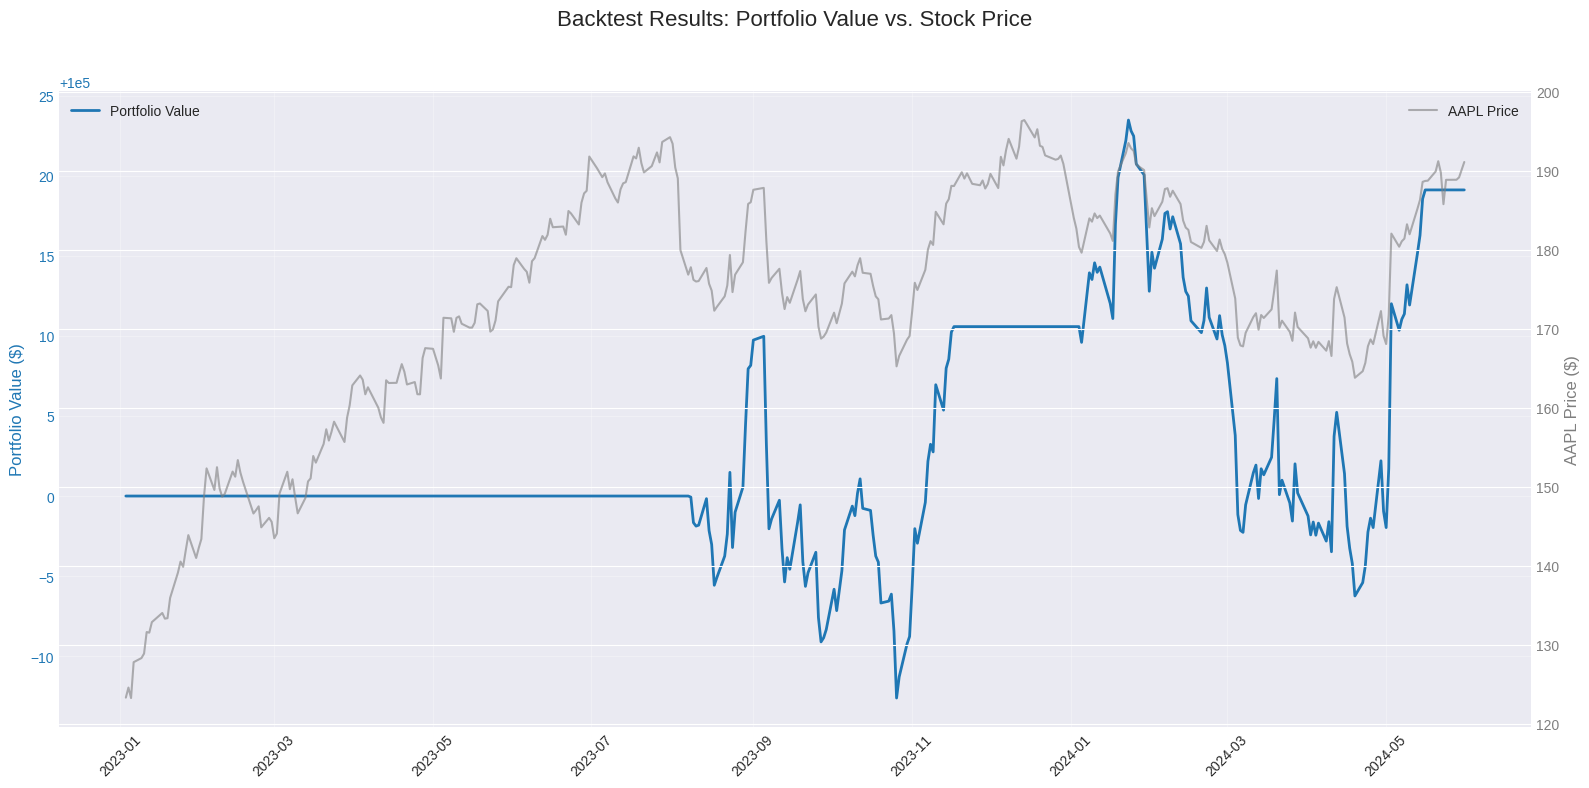

In [5]:
#!/usr/bin/env python3
import backtrader as bt
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
# Update this password
DB_CONFIG = {
    'host': 'localhost',
    'database': 'trading_historical', 
    'user': 'trading_bot',
    'password': 'your_secure_password'  # ⚠️ UPDATE THIS
}

# --- 2. STRATEGY DEFINITION ---
class SimpleStrategy(bt.Strategy):
    """ A simple RSI-based trading strategy. """
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=14)
        self.order = None
        
    def next(self):
        if self.order:
            return # An order is pending, do nothing
            
        # Check if we are in the market
        if not self.position:
            # Not in the market, check for a buy signal
            if self.rsi[0] < 30:
                self.order = self.buy()
                print(f"BUY SIGNAL: {self.data.datetime.date(0)} at ${self.data.close[0]:.2f}")
        else:
            # In the market, check for a sell signal
            if self.rsi[0] > 70:
                self.order = self.sell()
                print(f"SELL SIGNAL: {self.data.datetime.date(0)} at ${self.data.close[0]:.2f}")
    
    def notify_order(self, order):
        if order.status == order.Completed:
            self.order = None

# --- 3. DATA & PLOTTING FUNCTIONS ---
def get_data(symbol='AAPL', start_date='2023-01-01', end_date='2024-06-01'):
    """ Fetches data from the database using SQLAlchemy. """
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    engine = create_engine(db_url)
    
    query = f"""
    SELECT p.timestamp as datetime, p.open, p.high, p.low, p.close, p.volume
    FROM historical_prices p
    WHERE p.symbol = '{symbol}' AND p.timestamp >= '{start_date}' AND p.timestamp <= '{end_date}'
    ORDER BY p.timestamp;
    """
    df = pd.read_sql(query, engine, parse_dates=['datetime'])
    df.set_index('datetime', inplace=True)
    
    # --- FIX FOR TIMEZONE ERROR ---
    # Convert the timezone-aware index to a timezone-naive index
    df.index = df.index.tz_localize(None)
    
    return df

def plot_results(cerebro, results, data, symbol):
    """ 
    Generates a plot with two Y-axes:
    1. Portfolio Value (left axis)
    2. Stock Price (right axis)
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(16, 8))
    
    # --- Primary Y-Axis: Portfolio Value ---
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel('Portfolio Value ($)', color='tab:blue', fontsize=12)
    
    # --- PLOTTING LOGIC ---
    # 1. Get daily returns from the TimeReturn analyzer
    returns_dict = results[0].analyzers.timereturn.get_analysis()
    returns_series = pd.Series(returns_dict)

    # 2. Calculate the cumulative portfolio value over time
    initial_cash = cerebro.broker.startingcash
    cumulative_returns = (1 + returns_series).cumprod()
    portfolio_values = initial_cash * cumulative_returns

    # 3. Align the portfolio values with the main data index for plotting
    aligned_portfolio_values = portfolio_values.reindex(data.index, method='ffill').fillna(initial_cash)
    
    # 4. Plot the aligned portfolio values
    ax1.plot(aligned_portfolio_values.index, aligned_portfolio_values, color='tab:blue', label='Portfolio Value', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # --- Secondary Y-Axis: Stock Price ---
    ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis
    ax2.set_ylabel(f'{symbol} Price ($)', color='tab:gray', fontsize=12)
    ax2.plot(data.index, data['close'], color='tab:gray', alpha=0.6, label=f'{symbol} Price')
    ax2.tick_params(axis='y', labelcolor='tab:gray')
    ax2.legend(loc='upper right')

    # Format x-axis
    ax1.tick_params(axis='x', rotation=45)
    
    fig.suptitle('Backtest Results: Portfolio Value vs. Stock Price', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()

# --- 4. MAIN BACKTEST EXECUTION ---
def run_backtest():
    """ Main function to run the backtest. """
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SimpleStrategy)
    
    symbol_to_test = 'AAPL'
    print(f"📊 Loading {symbol_to_test} data...")
    data = get_data(symbol=symbol_to_test)
    print(f"✅ Loaded {len(data)} records")
    
    bt_data = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(bt_data)
    
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    
    # Add analyzers to track performance
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
    
    print(f"💰 Starting Portfolio Value: ${cerebro.broker.getvalue():,.2f}")
    
    results = cerebro.run()
    
    final_value = cerebro.broker.getvalue()
    print(f"💰 Final Portfolio Value: ${final_value:,.2f}")
    
    # Print performance summary
    strat = results[0]
    returns = strat.analyzers.returns.get_analysis()
    drawdown = strat.analyzers.drawdown.get_analysis()
    
    profit = final_value - 100000.0
    print("\n📊 PERFORMANCE SUMMARY:")
    print("==============================")
    print(f"💰 Profit/Loss: ${profit:,.2f}")
    print(f"📈 Total Return: {returns.get('rtot', 0):.2%}")
    print(f"📉 Max Drawdown: {drawdown.get('max', {}).get('drawdown', 0):.2%}")

    # Generate the improved plot
    plot_results(cerebro, results, data, symbol_to_test)

if __name__ == "__main__":
    run_backtest()